# QBUS3850 Lab 8: ARCH/GARCH Models

To install Kevin Sheppard's 'arch' package:

 - in the Anaconda Prompt: `conda install arch -c bashtage`, or
 - using pip3 in an Administrator cmd prompt: `pip3 install arch`

This tutorial uses arch version 4.13.


In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import statsmodels.api as sm
from scipy import stats
from arch import arch_model

from matplotlib.pylab import rcParams
rcParams['figure.figsize'] = 10, 5

In [3]:
## Plot diagnostics for G/ARCH models as introduced in Tutorial 8.
def assess_fit_plots( e, name ):
    #Plot standardised residuals.
    plt.plot( e )
    plt.title( '{0} Standardised Residuals'.format( name ) )
    plt.show()

    ## Plot the ACF of standardised residuals.
    sm.graphics.tsa.plot_acf( e, lags=20 )
    plt.title( 'ACF of {0} Standardised Residuals'.format( name ) )
    plt.show()

    ## Plot the histogram of standardised residuals.
    plt.hist( e, bins = 25 )
    plt.title( 'Histogram of {0} Standardised Residuals'.format( name ) )
    plt.show()

    ## QQ plot of standardised residuals against the normal distribution.
    sm.qqplot( e, line = 'r')
    plt.title( 'QQ Plot of {0} Standardised Residuals'.format( name ) )
    plt.show()

    ## Plot the ACF of squared standardised residuals.
    sm.graphics.tsa.plot_acf( e*e, lags=20 )
    plt.title( 'ACF of {0} Squared Standardised Residuals'.format( name ) )
    plt.show()

In [4]:
## Statistical diagnostics for G/ARCH models as introduced in Tutorial 8.
def assess_fit_stats( e, df ):
    ## Ljung-Box tests on standardised residuals
    from statsmodels.stats.diagnostic import acorr_ljungbox
    print( "Ljung-Box Q-statistic on standardised residuals:" )
    for p in [ df + 5, df + 10 ]:
        Qstat, pValue = acorr_ljungbox( e, lags = [p], model_df = df, return_df = False )
        print('maxlag: {0:d}. Q-stat: {1:f}. P-value: {2:f}'.format( p, Qstat[0], pValue[0] ) )
    print()

    ## Ljung-Box tests on squared standardised residuals
    print( "Ljung-Box Q-statistic on squared standardised residuals:" )
    for p in [ df + 5, df + 10 ]:
        Qstat, pValue = acorr_ljungbox( e*e, lags = [p], model_df = df, return_df = False )
        print('maxlag: {0:d}. Q-stat: {1:f}. P-value: {2:f}'.format( p, Qstat[0], pValue[0] ) )
    print()

    ## ARCH test on mean-corrected returns
    ## The null hypothesis is no ARCH errors.
    from statsmodels.stats.diagnostic import het_arch
    print( "Engle ARCH statistic:")
    for p in [ 5, 10 ]:
        Teststat, pValue, _, _ = het_arch( resid=e, nlags=p )
        print('maxlag: {0:d}. ARCH test statistic: {1:f}. P-value: {2:f}'.format( p, Teststat, pValue) )
    print()

    ## Jarque-Bera tests
    from statsmodels.stats.stattools import jarque_bera
    print( 'Skewness: {0:f}'.format( stats.skew( e ) ) )
    print( 'Kurtosis: {0:f}'.format( stats.kurtosis( e ) + 3 ) )
    JB_test_stat, JB_pvalue, _, _ = jarque_bera( e )
    print( 'JB test statistic: {0:f}. P-value {1:f}'.format( JB_test_stat, JB_pvalue ) )
    print()


## Import Data

Import Data for "BHP00-20.csv", containing daily prices for BHP stock between 2000-01-04 and 2020-04-06.

In [5]:
data = pd.read_csv('BHP00-20.csv', index_col='Date', parse_dates=['Date'], dayfirst = True)
print( data.tail() )

#BHPdates = BHPdata['Date']
BHPprices = data['Adj Close']

## Calculate log-returns. Drop first null observation
BHPr = ( 100 * ( np.log( BHPprices ) - np.log( BHPprices.shift(1) ) ) ).dropna()

                 Open       High        Low  Close  Adj Close      Volume
Date                                                                     
2020-03-31  30.330000  30.480000  28.450001  28.98      28.98  14599950.0
2020-04-01  29.950001  30.629999  29.650000  30.23      30.23  12416279.0
2020-04-02  29.500000  30.059999  29.260000  29.85      29.85   8658031.0
2020-04-03  31.120001  31.350000  30.000000  30.33      30.33  10409253.0
2020-04-06  30.700001  31.290001  30.549999  30.98      30.98   2505959.0


### Q1(a) Transform the prices to percentage log-returns. Plot the price and return series.

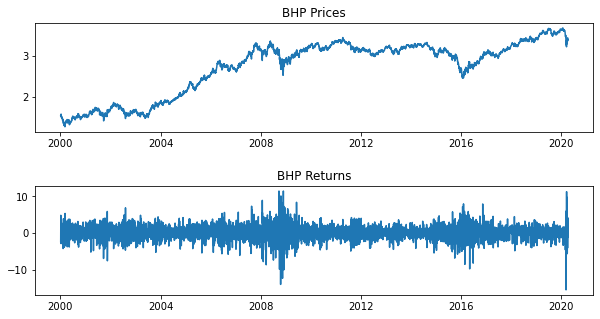

In [6]:
fig, axs = plt.subplots( 2, 1 )
axs[0].plot( np.log( BHPprices ) )
axs[0].set_title( 'BHP Prices' )

axs[1].plot( BHPr )
axs[1].set_title( 'BHP Returns' )

fig.subplots_adjust(hspace=0.5)
plt.show()

### Q1(b) Use an ACF plot and the Ljung-Box and Engle's ARCH tests with 5 and 10 lags and 5% significance level. Is there evidence of ARCH effects in the log-returns?

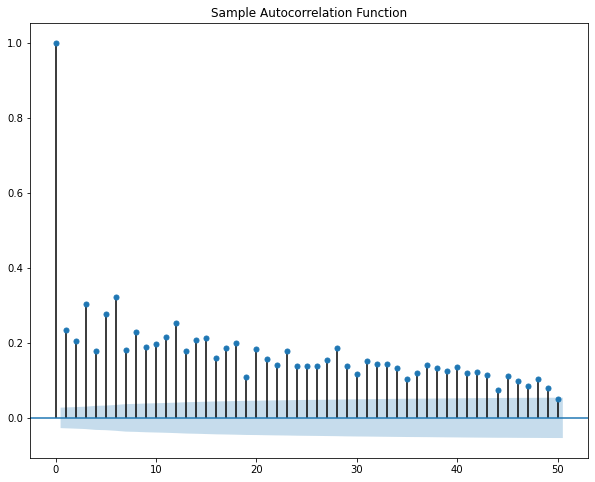

Ljung-Box Q-statistic:
maxlag: 5. Q-stat: 1536.508124. P-value: 0.000000
maxlag: 10. Q-stat: 2899.642781. P-value: 0.000000

Engle ARCH statistic:
maxlag: 5. ARCH test statistic: 856.627529. P-value: 0.000000
maxlag: 10. ARCH test statistic: 1046.537673. P-value: 0.000000


In [7]:
## ACF Plot shows substantial autocorrelation in returns-squared.
fig, ax = plt.subplots(figsize = (10,8))
sm.graphics.tsa.plot_acf( BHPr**2, ax=ax, lags=50 )
ax.set_title( 'Sample Autocorrelation Function' )
plt.show()

## Ljung-Box test. NH is no autocorrelation; strongly rejected.
from statsmodels.stats.diagnostic import acorr_ljungbox
print( "Ljung-Box Q-statistic:" )
for p in [ 5, 10 ]:
    Qstat, pValue = acorr_ljungbox( BHPr**2, lags=[p], return_df = False )
    print('maxlag: {0:d}. Q-stat: {1:f}. P-value: {2:f}'.format( p, Qstat[0], pValue[0] ) )
print()      
        
## ARCH test on mean-corrected returns
## NH is no ARCH effects; strongly rejected.
from statsmodels.stats.diagnostic import het_arch
print( "Engle ARCH statistic:")
a=BHPr-BHPr.mean()
for p in [ 5, 10 ]:
    Teststat, pValue, _, _ = het_arch( resid=a, nlags=p )
    print('maxlag: {0:d}. ARCH test statistic: {1:f}. P-value: {2:f}'.format( p, Teststat, pValue) )


### Q1(c) Fit an ARCH(1) model using ML. Comment on the parameter estimates and plot the estimated conditional volatility.

Iteration:      1,   Func. Count:      5,   Neg. LLF: 10406.855038935653
Iteration:      2,   Func. Count:     13,   Neg. LLF: 10406.713980099226
Iteration:      3,   Func. Count:     20,   Neg. LLF: 10406.683163159661
Iteration:      4,   Func. Count:     27,   Neg. LLF: 10406.604907834113
Iteration:      5,   Func. Count:     33,   Neg. LLF: 10406.443873326782
Iteration:      6,   Func. Count:     38,   Neg. LLF: 10406.441297840893
Optimization terminated successfully.    (Exit mode 0)
            Current function value: 10406.441297841175
            Iterations: 6
            Function evaluations: 38
            Gradient evaluations: 6
                      Constant Mean - ARCH Model Results                      
Dep. Variable:              Adj Close   R-squared:                      -0.000
Mean Model:             Constant Mean   Adj. R-squared:                 -0.000
Vol Model:                       ARCH   Log-Likelihood:               -10406.4
Distribution:                  Normal

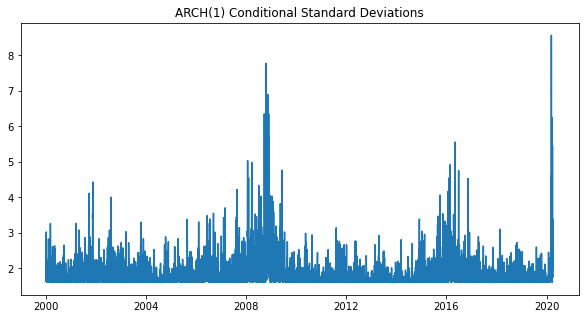

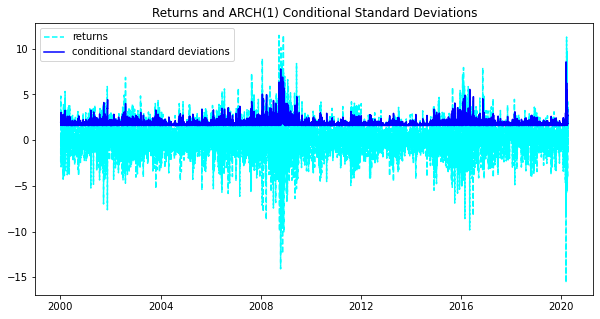

In [8]:
## Estimate ARCH(1) model
EstMdl = arch_model( y = BHPr, mean='constant', vol='ARCH', p=1 ).fit()
print( EstMdl.summary() )

## Infer the conditional standard deviations and conditional variance.
s = EstMdl.conditional_volatility 
v = s**2

#Plot the estimated conditional standard deviations against time
fig = plt.figure()
plt.plot( s )
plt.title( 'ARCH(1) Conditional Standard Deviations' )
plt.show()

## A common way to show conditional standard deviations plotted on top of the actual returns.
fig = plt.figure()
plt.plot( BHPr, color = 'cyan', ls = '--', label = 'returns')
plt.plot( s, color = 'b', label = 'conditional standard deviations')
plt.title( 'Returns and ARCH(1) Conditional Standard Deviations' )
plt.legend()
plt.show()

### Q1(d) Assess fit of ARCH(1) model using ACF plots and Ljung-Box tests, a histogram/qqplot, and the Jarque-Bera test.

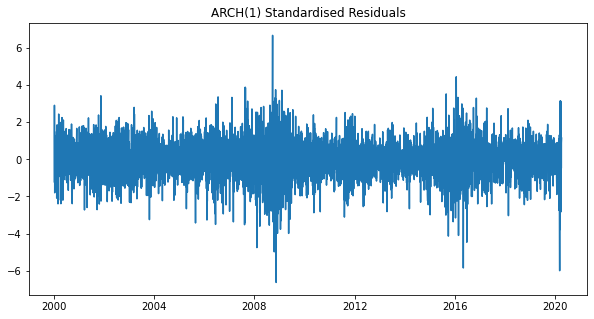

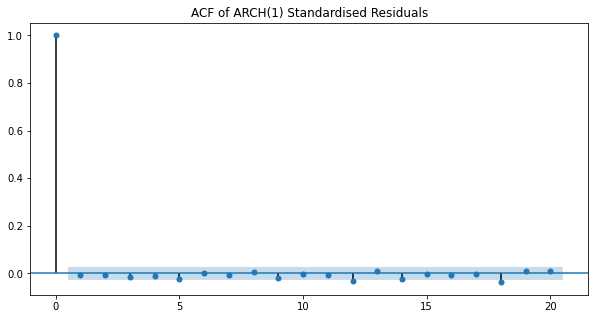

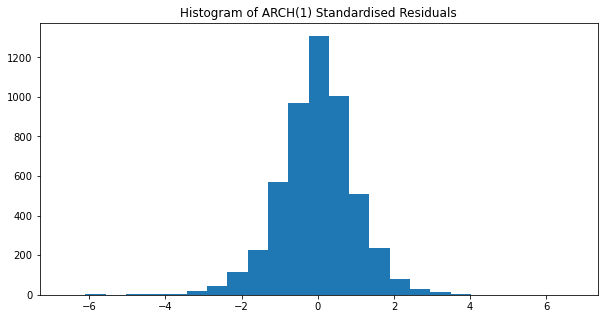

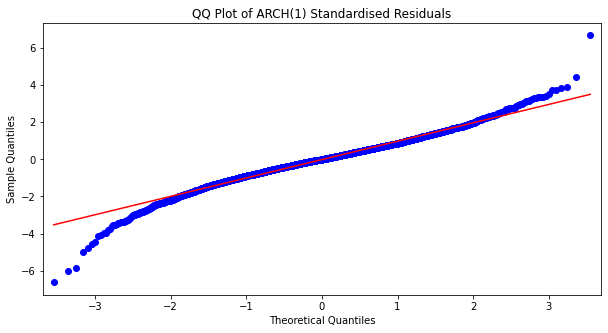

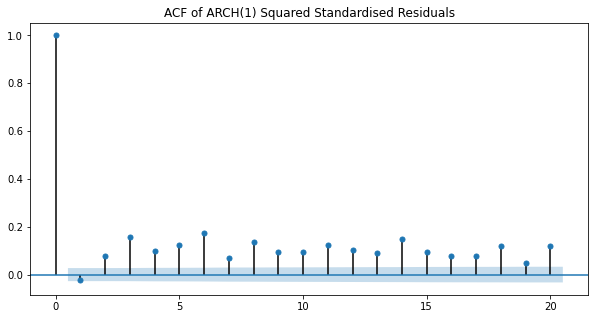

In [9]:
## Innovations/residuals
a = BHPr - EstMdl.params['mu'] 
## Standardised residuals
e = a / s

    
assess_fit_plots( e, 'ARCH(1)' )


In [10]:
assess_fit_stats( e, 1 )

Ljung-Box Q-statistic on standardised residuals:
maxlag: 6. Q-stat: 5.273964. P-value: 0.383368
maxlag: 11. Q-stat: 7.792996. P-value: 0.649049

Ljung-Box Q-statistic on squared standardised residuals:
maxlag: 6. Q-stat: 446.393227. P-value: 0.000000
maxlag: 11. Q-stat: 740.471516. P-value: 0.000000

Engle ARCH statistic:
maxlag: 5. ARCH test statistic: 283.025992. P-value: 0.000000
maxlag: 10. ARCH test statistic: 465.237573. P-value: 0.000000

Skewness: -0.249241
Kurtosis: 5.390588
JB test statistic: 1281.135693. P-value 0.000000



### Q1(e) Use the AIC and SIC functions to identify a suitable ARCH model order.

In [11]:
ps = range( 1, 21 )
LLF = []
aic = []
sic = []
for p in ps:
    ## Estimate model (disp = 'off' to suppress output)
    EstMdl = arch_model(y = BHPr, mean = 'Constant', vol = 'ARCH', p = p).fit( disp= 'off' )
    LLF.append( EstMdl.loglikelihood )
    aic.append( -2 * EstMdl.loglikelihood + 2*p )
    sic.append( -2 * EstMdl.loglikelihood + np.log( len( BHPr ) ) * p )


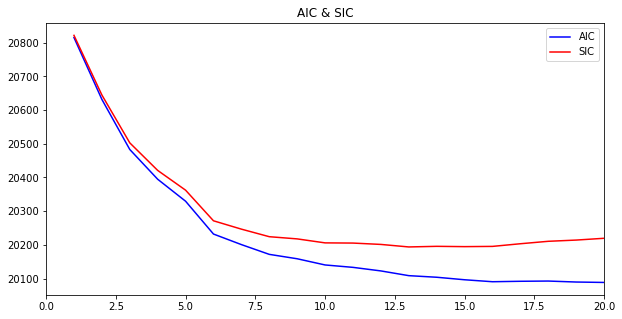

In [12]:
fig = plt.figure()
plt.plot( ps, aic, color = 'blue', label = 'AIC' )
plt.plot( ps, sic, color = 'red', label = 'SIC' )
plt.xlim( 0, 20 )
plt.legend()
plt.title( 'AIC & SIC' )
plt.show()

#AIC choses p=20
#SIC chooses p=15. 
# p=8 is also reasonable

### Q1(f) Fit the constant mean Gaussian ARCH model with lag order chosen in part (e). What is the fitted model? Are all chosen ARCH lags significant?

                      Constant Mean - ARCH Model Results                      
Dep. Variable:              Adj Close   R-squared:                      -0.000
Mean Model:             Constant Mean   Adj. R-squared:                 -0.000
Vol Model:                       ARCH   Log-Likelihood:               -10033.4
Distribution:                  Normal   AIC:                           20100.7
Method:            Maximum Likelihood   BIC:                           20212.0
                                        No. Observations:                 5156
Date:                Fri, Apr 24 2020   Df Residuals:                     5139
Time:                        10:46:27   Df Model:                           17
                                Mean Model                                
                 coef    std err          t      P>|t|    95.0% Conf. Int.
--------------------------------------------------------------------------
mu             0.0679  2.161e-02      3.141  1.681e-03 [2.553e-0

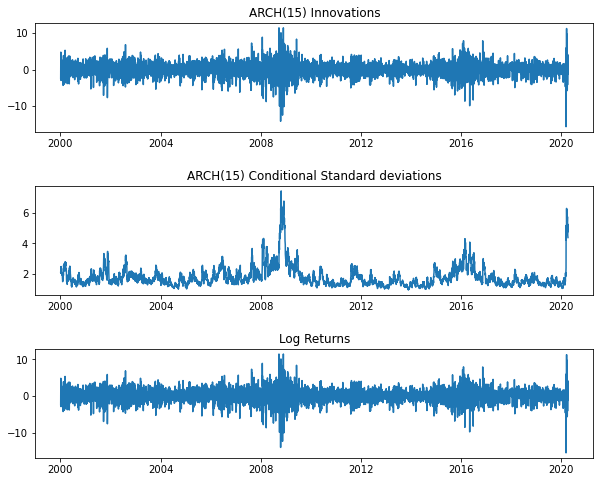

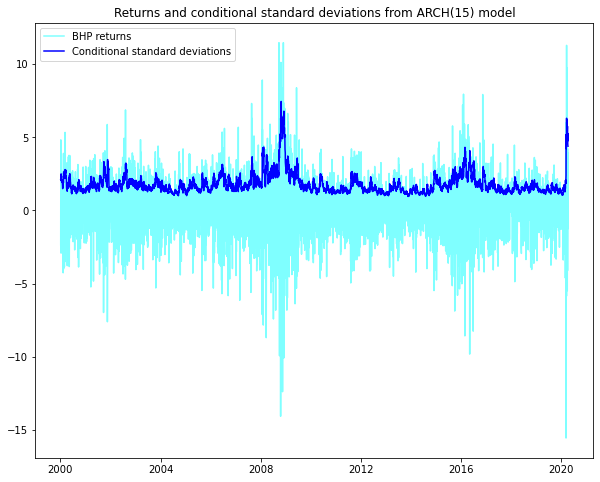

In [25]:
## Estimate ARCH(15) model
EstMdl = arch_model(y = BHPr, x=None, mean='Constant', vol='ARCH', p = 15 ).fit(disp = 'off')
print(EstMdl.summary())
coef_15 = EstMdl.params[2:]

## Infer the conditional standard deviations and variance.
s_15 = EstMdl.conditional_volatility
v_15 = s_15**2
a_15 = BHPr - EstMdl.params['mu']
e_15 = a_15 / s_15

## Another common way to show conditional standard deviation plots is below.
## The code plots the innovations, conditional standard deviations and log returns above one another 
## Also, sometimes innovations are replaced by standardised residuals.

fig, axs = plt.subplots(3, 1, figsize = (10,8))
axs[0].plot( a_15 )
axs[0].set_title( 'ARCH(15) Innovations' )

axs[1].plot( s_15 )
axs[1].set_title( 'ARCH(15) Conditional Standard deviations' )

axs[2].plot( BHPr )
axs[2].set_title( 'Log Returns' )

fig.subplots_adjust(hspace=0.5)
plt.show()

#Plot Returns and conditional standard deviations
fig = plt.figure(figsize= (10,8))
plt.plot( BHPr, color = 'cyan', alpha = 0.5, label = 'BHP returns' )
plt.plot( s_15, color = 'blue', label = 'Conditional standard deviations' )
plt.title( 'Returns and conditional standard deviations from ARCH(15) model' )
plt.legend()
plt.show()



### Q1(g) Compare the estimated volatility with that of the ARCH(1) model. How and why are they different?

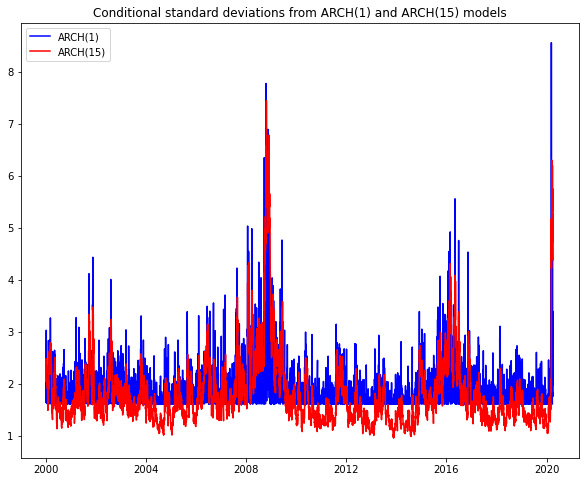

In [14]:
figure = plt.figure(figsize = (10,8))
plt.plot( s, color = 'blue', label = 'ARCH(1)' )
plt.plot( s_15, color = 'red', label = 'ARCH(15)' )
plt.title( 'Conditional standard deviations from ARCH(1) and ARCH(15) models' )
plt.legend()
plt.show()

### Q1(h) Assess the fit of the ARCH model in (f) using ACF plots, Ljung-Box and ARCH tests and a histogram/qqplot together with the Jarque-Bera test. Has the fit improved from the ARCH(1) model?

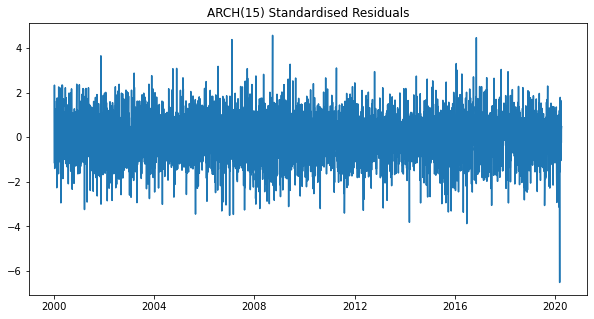

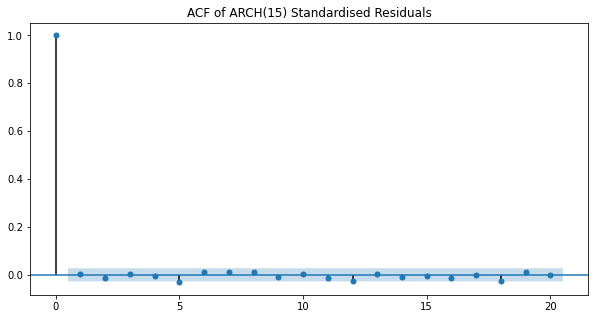

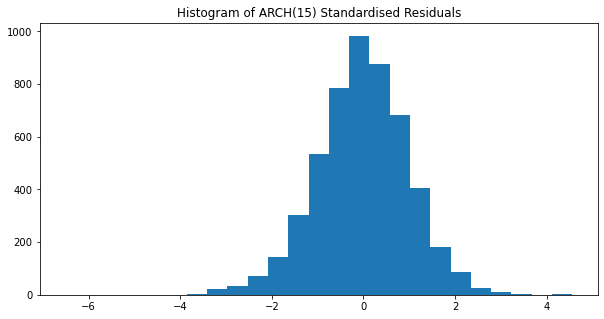

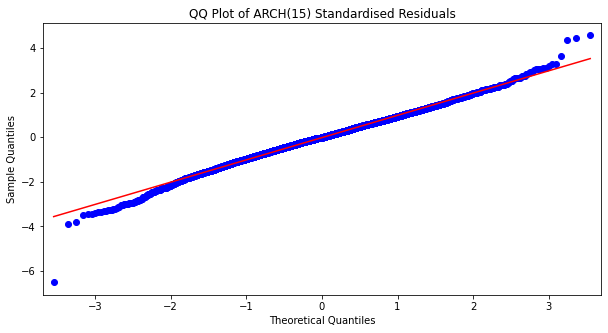

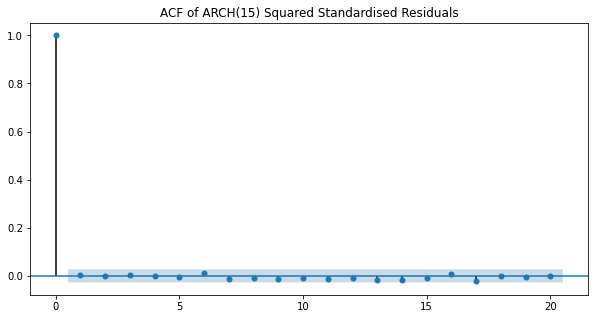

In [15]:
assess_fit_plots( e_15, 'ARCH(15)' )

In [16]:
assess_fit_stats( e_15, 15 )

Ljung-Box Q-statistic on standardised residuals:
maxlag: 20. Q-stat: 19.387622. P-value: 0.001627
maxlag: 25. Q-stat: 20.086626. P-value: 0.028444

Ljung-Box Q-statistic on squared standardised residuals:
maxlag: 20. Q-stat: 11.189611. P-value: 0.047748
maxlag: 25. Q-stat: 14.058476. P-value: 0.170341

Engle ARCH statistic:
maxlag: 5. ARCH test statistic: 0.239205. P-value: 0.998633
maxlag: 10. ARCH test statistic: 3.351932. P-value: 0.971888

Skewness: -0.167072
Kurtosis: 3.893323
JB test statistic: 195.429157. P-value 0.000000



### Q2(a) Fit a GARCH(1,1) model to the log-return series. Compare the estimated volatility series to that of the ARCH(p) model computed in Q1(f).

In [17]:
EstMdl = arch_model( BHPr, mean = 'Constant', vol = 'GARCH', p = 1, q = 1 ).fit( disp = 'off' )
print( EstMdl.summary() )

LLF = EstMdl.loglikelihood
s = EstMdl.conditional_volatility #infer the conditional standard deviations
v = s**2 #Conditional variance
a = BHPr - EstMdl.params['mu'] #Calculate innovations
e = a / s ## Standardised residuals


                     Constant Mean - GARCH Model Results                      
Dep. Variable:              Adj Close   R-squared:                      -0.000
Mean Model:             Constant Mean   Adj. R-squared:                 -0.000
Vol Model:                      GARCH   Log-Likelihood:               -10020.6
Distribution:                  Normal   AIC:                           20049.1
Method:            Maximum Likelihood   BIC:                           20075.3
                                        No. Observations:                 5156
Date:                Fri, Apr 24 2020   Df Residuals:                     5152
Time:                        10:27:23   Df Model:                            4
                                Mean Model                                
                 coef    std err          t      P>|t|    95.0% Conf. Int.
--------------------------------------------------------------------------
mu             0.0628  2.143e-02      2.928  3.407e-03 [2.075e-0

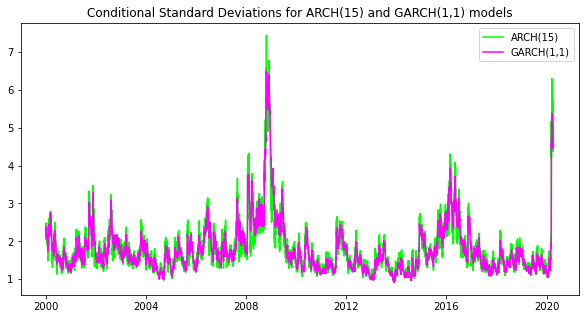

In [18]:
#Plot conditional standard deviations for ARCH(15) and GARCH model for comparison
plt.plot( s_15, color = 'lime', label = 'ARCH(15)')
plt.plot( s, color = 'magenta', label = 'GARCH(1,1)')
plt.title( 'Conditional Standard Deviations for ARCH(15) and GARCH(1,1) models' )
plt.legend()
plt.show()


### Q2(b) Assess fit of the GARCH(1,1) model using ACF plots and Ljung-Box tests, a histogram/qqplot, and the Jarque-Bera test.

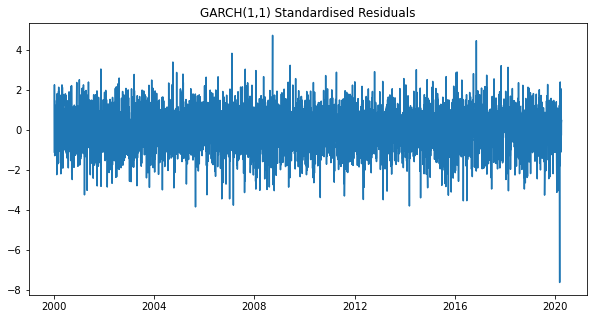

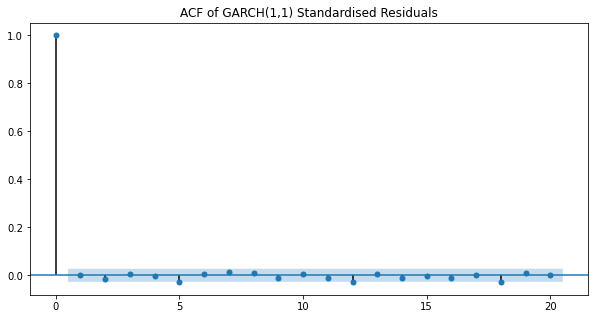

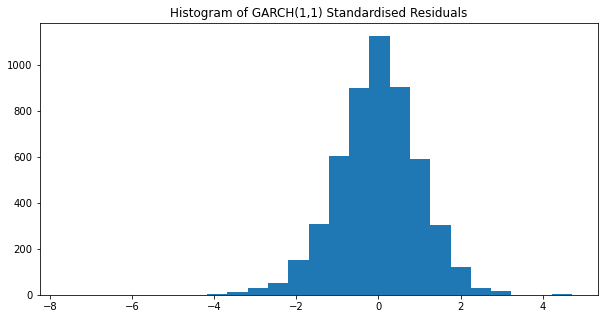

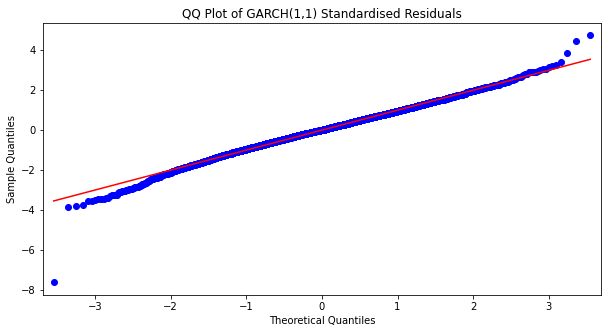

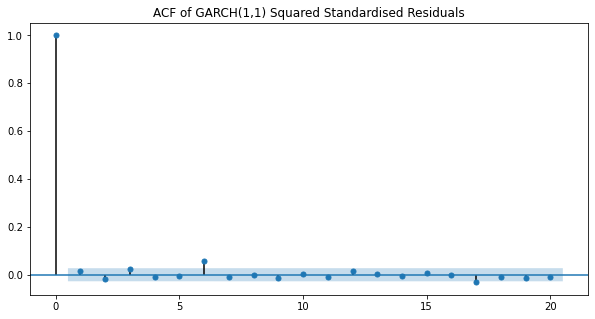

In [19]:
assess_fit_plots( e, 'GARCH(1,1)')

In [20]:
assess_fit_stats( e, 2 )

Ljung-Box Q-statistic on standardised residuals:
maxlag: 7. Q-stat: 6.883003. P-value: 0.229488
maxlag: 12. Q-stat: 13.193195. P-value: 0.213070

Ljung-Box Q-statistic on squared standardised residuals:
maxlag: 7. Q-stat: 23.636625. P-value: 0.000255
maxlag: 12. Q-stat: 25.786663. P-value: 0.004038

Engle ARCH statistic:
maxlag: 5. ARCH test statistic: 6.256621. P-value: 0.282043
maxlag: 10. ARCH test statistic: 25.119994. P-value: 0.005123

Skewness: -0.221717
Kurtosis: 4.159109
JB test statistic: 330.879197. P-value 0.000000



### Q2(c) Using the estimates in (a), find the weights on the previous 20 lagged squared shocks in the GARCH equation for each $\sigma_t^2$. How do these compare to the ARCH(p) model from Q1(f)?

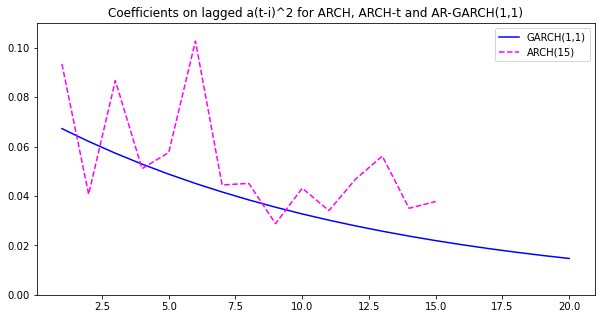

In [21]:
#Get AR(1)-GARCH(1,1) model parameter estimates for variance equation
alpha1 = EstMdl.params['alpha[1]'] 
alpha0 = EstMdl.params['omega'] 
beta1 = EstMdl.params['beta[1]'] 

#Calculate lagged effects for AR(1)-GARCH(1,1) model
coef_g1 = []
for i in range(1,21): #GARCH Model effects
    coef_g1.append( alpha1 * ( beta1**(i-1) ) )

#print( coef_g1 )
#print( coef_15 )

plt.plot( range( 1, 1 + len( coef_g1 ) ), coef_g1, color = 'blue', label = 'GARCH(1,1)')
plt.plot( range( 1, 1 + len( coef_15 ) ), coef_15, color = 'magenta', ls = '--', label = 'ARCH(15)')
plt.ylim( 0, 0.11 )
plt.legend()
plt.title('Coefficients on lagged a(t-i)^2 for ARCH, ARCH-t and AR-GARCH(1,1)')
plt.show()

### Q2(d) Use AIC or SIC to choose a suitable GARCH model order. Fit this model and assess its fit to the data.

In [97]:
aic = np.zeros( ( 6, 6 ) )
sic = np.zeros( ( 6, 6 ) )

for p in range( 1, 6 ):
    for q in range( 0, 6 ):    
        Mdl = arch_model( BHPr, mean = 'Constant', lags = 1, vol = 'GARCH', p = p, q = q, dist = 'gaussian')
        EstMdl = Mdl.fit(disp='off')
        aic[ p, q ] = -2 * EstMdl.loglikelihood + 2 * ( p + q )
        sic[ p, q ] = -2 * EstMdl.loglikelihood + np.log( len( BHPr ) ) * ( p + q )

In [99]:
## AIC favours GARCH( 1, 2 ).
## SIC favours GARCH( 1, 1 ).
with np.printoptions( precision = 2, suppress = True ):
    print( aic )
    print( sic )


[[    0.       0.       0.       0.       0.       0.  ]
 [20814.88 20045.11 20041.67 20043.62 20045.62 20047.4 ]
 [20631.54 20047.11 20043.67 20044.63 20046.63 20047.86]
 [20483.03 20049.07 20045.06 20042.4  20044.4  20044.78]
 [20394.78 20051.07 20047.06 20044.4  20046.5  20046.33]
 [20329.64 20053.07 20049.06 20046.4  20048.5  20045.42]]
[[    0.       0.       0.       0.       0.       0.  ]
 [20821.43 20058.2  20061.31 20069.82 20078.36 20086.69]
 [20644.64 20066.75 20069.86 20077.37 20085.92 20093.69]
 [20502.67 20075.26 20077.8  20081.69 20090.24 20097.16]
 [20420.98 20083.81 20086.35 20090.24 20098.88 20105.27]
 [20362.38 20092.35 20094.9  20098.78 20107.43 20110.9 ]]


In [55]:
EstMdl = arch_model( BHPr, mean = 'Constant', vol = 'GARCH', p = 1, q = 2 ).fit( disp = 'off' )
print( EstMdl.summary() )

LLF = EstMdl.loglikelihood
s = EstMdl.conditional_volatility #infer the conditional standard deviations
v = s**2 #Conditional variance
a = BHPr - EstMdl.params['mu'] #Calculate innovations
e = a / s ## Standardised residuals

                     Constant Mean - GARCH Model Results                      
Dep. Variable:              Adj Close   R-squared:                      -0.000
Mean Model:             Constant Mean   Adj. R-squared:                 -0.000
Vol Model:                      GARCH   Log-Likelihood:               -10017.8
Distribution:                  Normal   AIC:                           20045.7
Method:            Maximum Likelihood   BIC:                           20078.4
                                        No. Observations:                 5156
Date:                Mon, Apr 20 2020   Df Residuals:                     5151
Time:                        17:00:06   Df Model:                            5
                                Mean Model                                
                 coef    std err          t      P>|t|    95.0% Conf. Int.
--------------------------------------------------------------------------
mu             0.0630  2.155e-02      2.922  3.481e-03 [2.073e-0

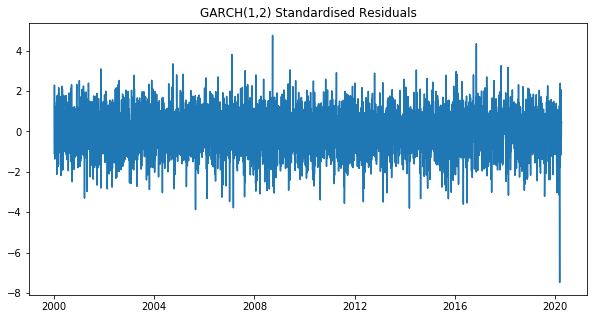

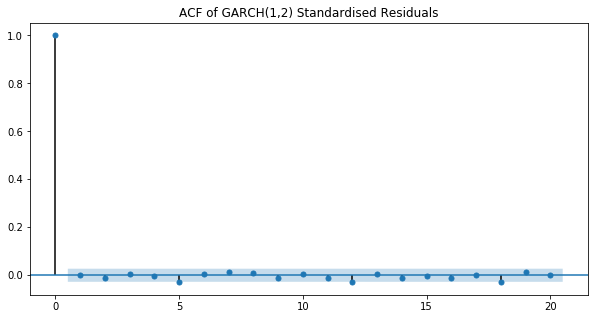

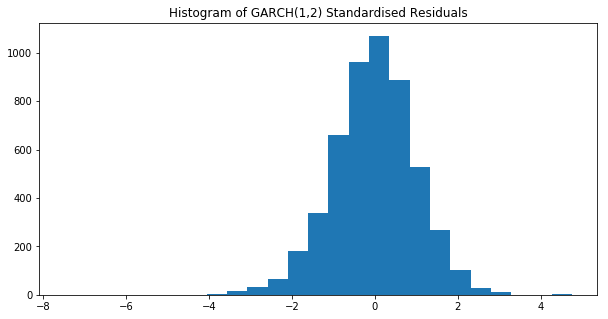

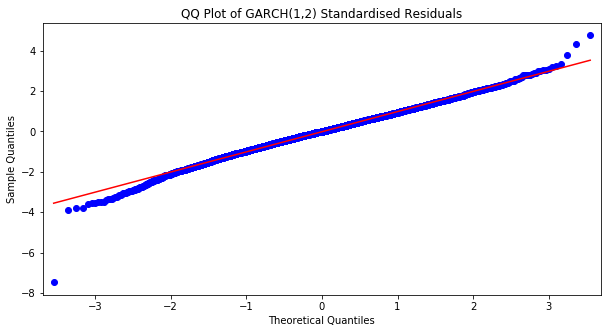

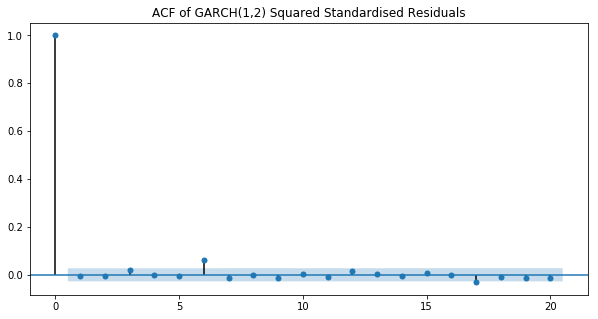

In [56]:
assess_fit_plots( e, 'GARCH(1,2)')

In [57]:
assess_fit_stats( e, 3 )

Ljung-Box Q-statistic on standardised residuals:
maxlag: 8. Q-stat: 7.233601. P-value: 0.203839
maxlag: 13. Q-stat: 13.303560. P-value: 0.207191

Ljung-Box Q-statistic on squared standardised residuals:
maxlag: 8. Q-stat: 22.217329. P-value: 0.000476
maxlag: 13. Q-stat: 24.536249. P-value: 0.006297

Engle ARCH statistic:
maxlag: 5. ARCH test statistic: 2.231179. P-value: 0.816320
maxlag: 10. ARCH test statistic: 23.124304. P-value: 0.010297

Skewness: -0.221076
Kurtosis: 4.106971
JB test statistic: 305.253234. P-value 0.000000

